# Importing Libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install scikit-plot
!pip install eli5

In [0]:
import datetime
import warnings
# linear algebra
import numpy as np
# data processing
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from datetime import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import eli5
from eli5.sklearn import PermutationImportance

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import gc
# Enable automatic garbage collection.
gc.enable()
#For Repreduciton the 
seed = 127
np.random.seed(seed)

In [0]:
paribas_data = pd.read_csv('/content/drive/My Drive/Project with Enas Kh/Thesis/Codes and Dataset/AwE/Gender/7_Wrapper_Gender_ML/Gender_Wrapper.csv')

In [0]:
paribas_data.shape

(344, 25)

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
   paribas_data.drop(labels=[], axis=1),
    paribas_data['target'],
    test_size=0.2,
    random_state=41)

# Load & Explore Dataset

In [0]:
#load data
train_df = train_features
test_df = test_features

In [0]:
train_features.shape

(275, 25)

In [0]:
test_features.shape

(69, 25)

In [0]:
#Explore the train data
train_df.head()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
214,215,0,24,22.00000,88.812121,19.872727,81.000000,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
275,276,1,3,120.00000,153.000000,7.000000,295.000000,9279.928571,30.800000,87.830000,0.640000,56.320000,18.360000,21.640000,11.960000,22.000000,62.000000,3.000000,0.000000,32.080000,1.600000,5.720000,2.080000,2.200000,2.640000
36,37,1,24,110.00000,119.000000,8.000000,181.000000,14500.000000,42.810000,31.620000,0.000000,10.360000,3.640000,1.320000,6.400000,20.000000,29.000000,3.000000,2.000000,60.000000,20.000000,22.000000,24.000000,6.000000,3.000000
202,203,0,24,32.00000,88.812121,19.872727,73.000000,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
108,109,0,24,70.21327,88.812121,19.872727,166.687273,14075.000000,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892


In [0]:
#Explore the test data
test_df.head()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
329,330,1,3,120.00000,120.000000,9.000000,272.0,9279.928571,42.940000,89.960000,0.000000,27.460000,25.800000,12.240000,48.000000,25.000000,60.000000,4.000000,0.000000,33.600000,2.320000,3.280000,4.960000,4.840000,1.680000
261,262,1,24,34.00000,21.000000,15.000000,143.0,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
200,201,0,24,56.00000,88.812121,19.872727,5.0,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
339,340,0,3,120.00000,120.000000,14.000000,199.0,9279.928571,22.790000,88.350000,0.000000,41.080000,34.720000,11.480000,15.440000,16.000000,45.000000,6.000000,1.000000,20.600000,5.200000,2.040000,3.960000,19.280000,1.240000
169,170,1,24,70.21327,88.812121,19.872727,39.0,14612.500000,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,4.000000,30.000000,23.000000,27.000000,16.000000,3.000000


In [0]:
#Size Dataset
train_df.shape , test_df.shape

((275, 25), (69, 25))

In [0]:
#count of target in train data
train_df.groupby('target').count()['id']

target
0    133
1    142
Name: id, dtype: int64

In [0]:
#data type for train data
pd.DataFrame(train_df.dtypes).transpose()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
0,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [0]:
#data type for test data
pd.DataFrame(test_df.dtypes).transpose()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
0,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# Check for Missing data & data type

In [0]:
#Finding the missing values in train and test data
train_missing=train_df.isnull().sum().sum()
test_missing=test_df.isnull().sum().sum()
print('Missing values in train data :',train_missing)
print('Missing values in test data :',test_missing)

Missing values in train data : 0
Missing values in test data : 0


# Describe Data

In [0]:
# describe train
train_df.describe()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,170.527273,0.516364,20.105455,67.897188,89.395482,20.715923,167.845408,9437.328571,32.286334,83.814486,0.403209,22.543370,28.749763,9.737329,21.465226,18.877512,46.917236,3.555173,0.816424,30.690045,17.330738,12.411692,14.022760,14.452844,8.878779
std,98.245272,0.500643,8.176864,33.731364,29.104651,17.062413,71.706644,5045.566434,10.659171,33.201667,0.523954,9.253268,20.039940,5.887674,10.295668,4.154255,16.075304,1.357136,1.072640,11.381491,11.292635,7.961378,9.018814,8.946866,6.792656
min,1.000000,0.000000,3.000000,-18.666667,6.000000,4.000000,3.000000,0.000000,0.000000,0.800000,0.000000,0.000000,-0.600000,0.000000,1.400000,5.000000,2.000000,0.500000,0.000000,2.000000,-17.180000,0.000000,0.818667,2.160000,0.840000
25%,87.000000,0.000000,24.000000,48.000000,88.812121,15.000000,122.000000,9279.928571,32.216187,84.548345,0.000000,22.875252,28.491691,9.810288,21.545971,18.942446,47.158273,3.553957,0.000000,30.495827,16.924029,12.550725,13.696978,14.153094,8.524892
50%,172.000000,1.000000,24.000000,70.213270,88.812121,19.872727,166.687273,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
75%,253.500000,1.000000,24.000000,79.000000,120.000000,19.872727,208.500000,13425.000000,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
max,343.000000,1.000000,24.000000,120.000000,153.000000,143.333333,569.000000,22387.500000,95.510000,211.920000,6.160000,58.920000,179.980000,33.720000,94.120000,33.000000,121.000000,10.000000,11.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000


In [0]:
# describe test
test_df.describe()

,id,target,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,180.362319,0.507246,17.913043,76.114179,87.391129,20.779139,177.631304,8652.609731,31.566727,88.112093,0.500481,24.645178,26.704632,10.773133,21.943493,19.242039,48.493570,3.438849,0.959629,30.090821,14.153926,12.799427,12.001489,14.564925,6.998326
std,104.476985,0.503610,9.597394,38.956962,28.337131,24.803243,114.986276,5431.913512,14.189590,39.597119,1.024978,12.900878,22.861239,6.868251,9.454507,5.326994,16.059601,1.449331,1.466693,13.590091,10.853490,10.547964,10.142638,12.215298,5.614938
min,10.000000,0.000000,3.000000,-70.666667,7.000000,5.000000,5.000000,0.000000,0.000000,7.840000,0.000000,0.000000,-12.432000,0.000000,6.480000,4.000000,8.000000,-1.000000,0.000000,4.000000,-28.264000,1.648000,-0.823619,2.080000,1.000000
25%,87.000000,0.000000,3.000000,67.000000,88.812121,12.000000,110.000000,9279.928571,28.190000,84.548345,0.000000,21.520000,16.640000,9.810288,19.360000,18.942446,47.158273,3.000000,0.000000,25.120000,7.000000,6.920000,4.960000,7.720000,3.000000
50%,174.000000,1.000000,24.000000,70.213270,88.812121,19.872727,166.687273,9279.928571,32.216187,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,18.942446,47.158273,3.553957,0.848921,30.495827,16.924029,12.550725,13.696978,14.306187,8.524892
75%,280.000000,1.000000,24.000000,120.000000,107.000000,19.872727,241.000000,11762.500000,32.216187,87.210000,0.423309,22.875252,28.543381,11.480000,21.545971,20.600000,56.000000,3.553957,0.848921,33.000000,16.924029,12.550725,13.696978,14.306187,8.524892
max,344.000000,1.000000,24.000000,120.000000,120.000000,190.833333,838.000000,18987.500000,98.960000,186.970000,7.080000,57.860000,167.880000,36.166667,64.480000,31.000000,98.000000,8.000000,8.000000,60.000000,60.000000,59.000000,60.000000,60.000000,36.000000


# Distribution of target value

There are 51.63636363636363% target values with 1
There are 48.36363636363637% target values with 0


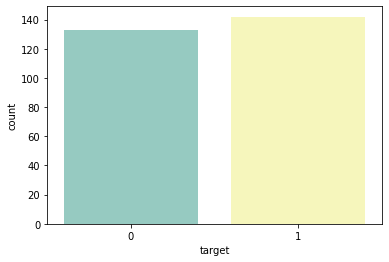

In [0]:
#The distribution of target value in train dataset
sns.countplot(train_df['target'], palette='Set3')

#The data is unbalanced with respect with target value
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0])),
print("There are {}% target values with 0".format(100 * train_df["target"].value_counts()[0]/train_df.shape[0]))

# scaling dataset

In [0]:
data= train_df 
y = data['target']
X = data.drop(['target', 'id'], axis=1)

#scaling dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
0,0.477157,-1.363149,-0.020080,-0.049508,-1.213329,-0.031253,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193
1,-2.095747,1.547456,2.189357,-0.805333,1.776494,-0.031253,-0.139696,0.121164,0.452754,3.656893,-0.519398,2.025311,-0.924909,0.753006,0.939967,-0.409823,-0.762522,0.122347,-1.395548,-0.842052,-1.326619,-1.372009,-0.920134
2,0.477157,1.250456,1.019029,-0.746618,0.183785,1.005219,0.989087,-1.574910,-0.770954,-1.319056,-1.255270,-1.432259,-1.465926,0.270695,-1.116614,-0.409823,1.105435,2.579925,0.236803,1.206548,1.108287,-0.946505,-0.867039
3,0.477157,-1.066148,-0.020080,-0.049508,-1.325098,-0.031253,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193
4,0.477157,0.068788,-0.020080,-0.049508,-0.016180,0.920834,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193


In [0]:
#splitting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)
X_train.head()

,C,F,G,J,K,L,N,P,Q,R,S,T,U,W,AA,AD,AG,AH,AI,AJ,AL,AM,AN
69,0.477157,0.068788,-0.020080,-0.049508,-0.016180,0.724760,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193
39,0.477157,0.068788,-0.020080,-0.049508,-0.016180,-1.873830,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193
95,-2.095747,1.547456,-0.942991,0.075395,0.281583,-0.031253,-1.375625,-0.281054,-0.770954,1.257697,0.430437,1.439974,-0.648562,1.958786,0.254440,1.804745,-0.762522,-1.634575,0.321969,-1.003121,0.997205,-1.062959,-0.507173
76,0.477157,-1.452249,1.053451,1.190984,-0.095638,-0.031253,-0.006593,0.022143,0.038432,0.035932,-0.010317,0.012414,0.007857,0.015659,0.015022,-0.000898,0.030352,-0.017095,-0.036081,0.017495,-0.036188,-0.016422,-0.052193
15,0.477157,0.068788,-0.020080,-0.049508,-0.291234,0.893532,-0.671662,0.605454,-0.770954,-0.803706,1.428264,-1.187235,3.259219,-0.211617,1.313891,3.281124,-0.762522,-1.733160,-0.827774,0.577372,-1.113343,-0.386631,-1.162011


In [0]:
#size after scale and split
X_train.shape, X_test.shape

((192, 23), (83, 23))

In [0]:
#The scatter plot for train and test set for few of the features
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [0]:
#The scatter plot for 16 features
#features = ['var_0','var_1','var_2','var_5','var_6','var_9','var_11','var_12','var_13','var_16','var_18',
 #           'var_21','var_22','var_23','var_24','var_26']
#plot_feature_scatter(train_df[::20],test_df[::20], features)

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

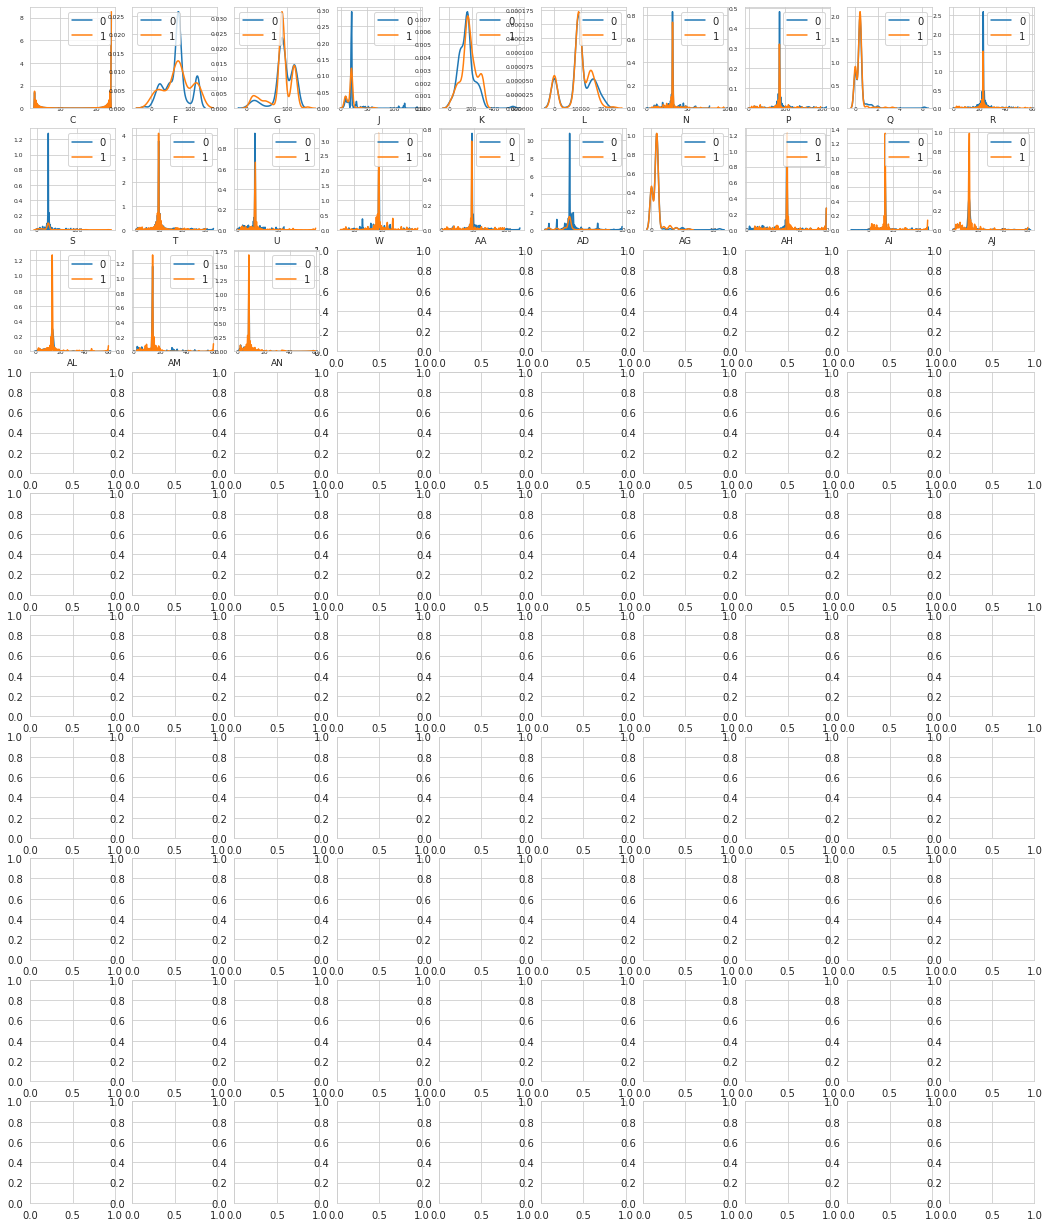

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

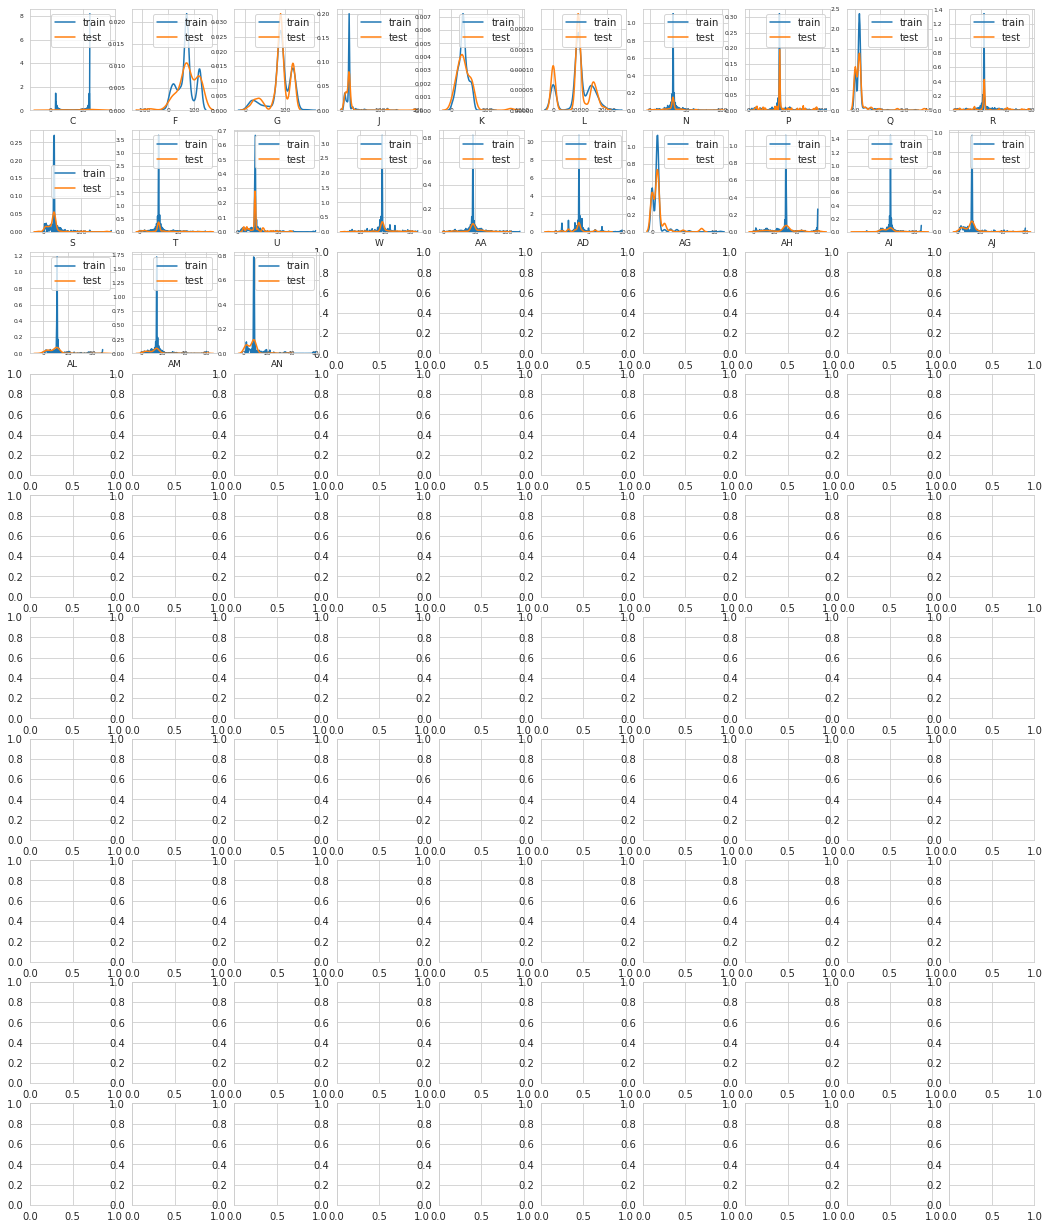

In [0]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

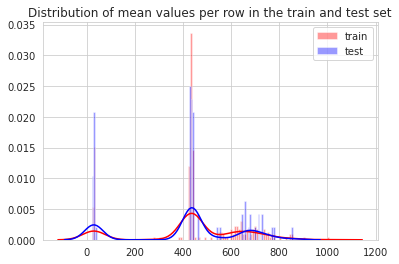

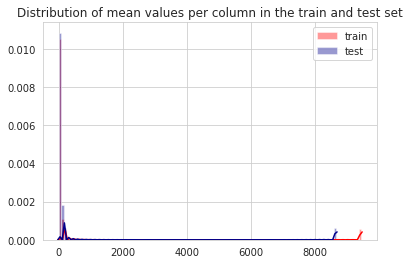

In [0]:
#The distribution of the mean values per row in the train & test set
#plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#The distribution of the mean values per column in the train & test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="red",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

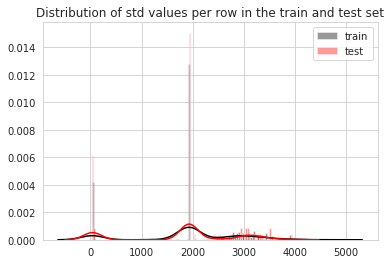

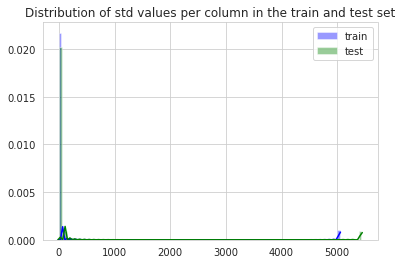

In [0]:
# The distribution of std values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

# The distribution of std values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

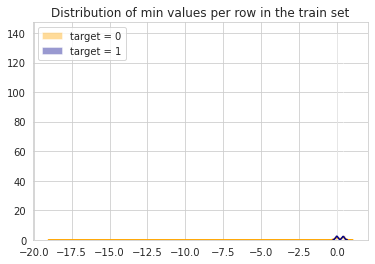

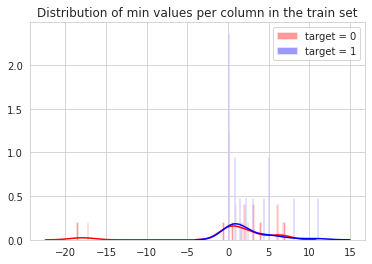

In [0]:
# The distribution of min values per row in the train and test set
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of min values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

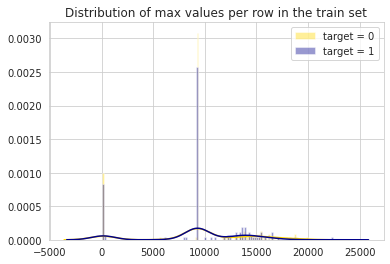

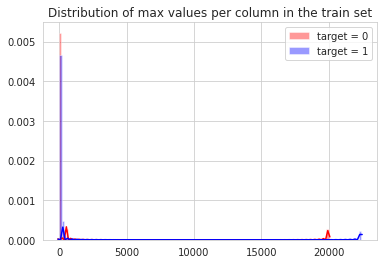

In [0]:
# The distribution of max values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of max values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

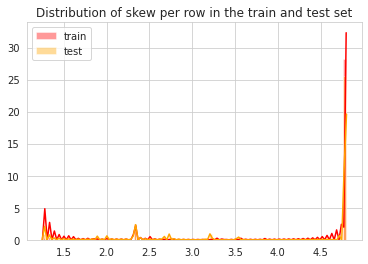

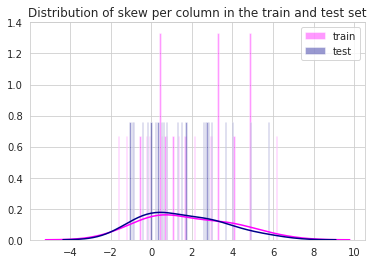

In [0]:
#Distribution of skew per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of skew per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

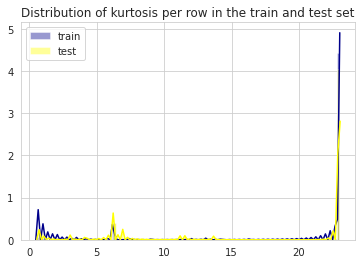

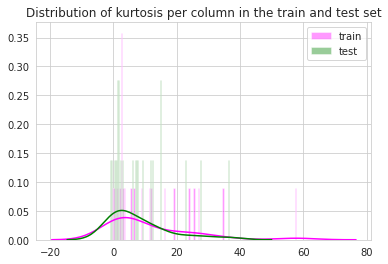

In [0]:
#Distribution of kurtosis per row in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of kurtosis per column in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()


# Correlation between the attributes

In [0]:
#Correlation between the attributes for train data
#Correlations in train attributes
train_attributes=train_df.columns.values[2:202]
train_correlations=train_df[train_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlations=train_correlations[train_correlations['level_0']!=train_correlations['level_1']]
train_correlations.head(10)

#print(train_correlations.head(10))
#print(train_correlations.tail(10))

,level_0,level_1,0
0,L,F,0.002063
1,F,L,0.002063
2,J,W,0.002350
3,W,J,0.002350
4,J,AA,0.003959
5,AA,J,0.003959
6,L,AD,0.004959
7,AD,L,0.004959
8,F,AL,0.005594
9,AL,F,0.005594


In [0]:
train_correlations.tail(10)

,level_0,level_1,0
496,W,R,0.566560
497,R,W,0.566560
498,C,R,0.566682
499,R,C,0.566682
500,T,R,0.623157
501,R,T,0.623157
502,T,C,0.647753
503,C,T,0.647753
504,P,AA,0.764063
505,AA,P,0.764063


In [0]:
#Correlation between the attributes for test data
#Correlations in test attributes
test_attributes=test_df.columns.values[1:201]
test_correlations=test_df[test_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
test_correlations=test_correlations[test_correlations['level_0']!=test_correlations['level_1']]
test_correlations.head(10)

#print(test_correlations.head(10))
#print(test_correlations.tail(10))

,level_0,level_1,0
0,C,AH,0.000190
1,AH,C,0.000190
2,P,C,0.000589
3,C,P,0.000589
4,W,G,0.000978
5,G,W,0.000978
6,AM,S,0.001785
7,S,AM,0.001785
8,F,S,0.003146
9,S,F,0.003146


In [0]:
test_correlations.tail(10)

,level_0,level_1,0
542,T,C,0.704037
543,C,T,0.704037
544,R,W,0.733905
545,W,R,0.733905
546,AA,P,0.735354
547,P,AA,0.735354
548,R,T,0.740899
549,T,R,0.740899
550,C,R,0.741501
551,R,C,0.741501


# Correlation plot for train and test data

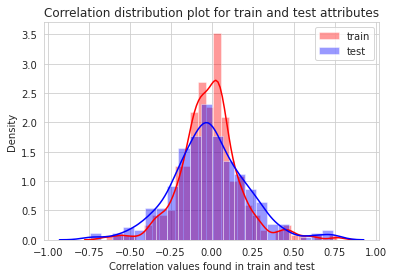

In [0]:
#Correlation plot for train and test data
# correlation between the train and test attributes is very very small
#it means that features are independent each other.
#Correlations in train data
train_correlations=train_df[train_attributes].corr()
train_correlations=train_correlations.values.flatten()
train_correlations=train_correlations[train_correlations!=1]
#Correlations in test data
test_correlations=test_df[test_attributes].corr()
test_correlations=test_correlations.values.flatten()
test_correlations=test_correlations[test_correlations!=1]

#plt.figure(figsize=(20,5))
#Distribution plot for correlations in train data
sns.distplot(train_correlations, color="Red", label="train")
#Distribution plot for correlations in test data
sns.distplot(test_correlations, color="Blue", label="test")
plt.xlabel("Correlation values found in train and test")
plt.ylabel("Density")
plt.title("Correlation distribution plot for train and test attributes")
plt.legend()

In [0]:
#Feature engineering
#Permutation variable importance measure in a random forest for classification
X=train_df.drop(columns=['id','target'],axis=1)
test=test_df.drop(columns=['id'],axis=1)
Y=train_df['target']

In [0]:
#build simple model to find features which are more important
#Split the training data
x_train,x_test,y_train, y_test = train_test_split(X, Y, random_state=42)

print('Shape of X_train :',x_train.shape)
print('Shape of X_test :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of X_train : (206, 23)
Shape of X_test : (69, 23)
Shape of y_train : (206,)
Shape of y_test: (69,)


In [0]:
#Split the train data using StratefiedKFold cross validator
#Training data
X=train_df.drop(['id','target'],axis=1)
Y=train_df['target']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True) #SPLITS=5
for train_index,test_index in cv.split(X,Y):
    x_train, x_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=Y.iloc[train_index], Y.iloc[test_index]

print('Shape of X_train :',x_train.shape)
print('Shape of X_valid :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_test.shape)

Shape of X_train : (220, 23)
Shape of X_valid : (55, 23)
Shape of y_train : (220,)
Shape of y_valid : (55,)


In [0]:
# Importing Classifier Modules
import datetime, time, json
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# XGB Classifier

In [0]:
 #XGB
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)
acc_xgb = round (metrics.accuracy_score(y_test, y_pred_xgb) *100, 2)
Precision_xgb= round (metrics.precision_score(y_test, y_pred_xgb) *100, 2)
Recall_xgb = round (metrics.recall_score(y_test, y_pred_xgb) *100, 2)
F1_xgb = round (metrics.f1_score(y_test, y_pred_xgb) *100, 2)
ROC_xgb= round (metrics.roc_auc_score(y_test, y_pred_xgb)* 100, 2)  

print("Accuracy for XGBClassifier is: {}".format(acc_xgb))
print("precision_score for XGBClassifier is: {}".format(Precision_xgb))
print("Recall_score for XGBClassifier is: {}".format(Recall_xgb))
print("F1_score for XGBClassifier is: {}".format(F1_xgb))
print("ROC for XGBClassifier is: {}".format(ROC_xgb))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:39:57.669323
Accuracy for XGBClassifier is: 63.64
precision_score for XGBClassifier is: 66.67
Recall_score for XGBClassifier is: 62.07
F1_score for XGBClassifier is: 64.29
ROC for XGBClassifier is: 63.73
Training ended at 2020-03-17 08:39:57.801667
Minutes elapsed: 0.002196


# MLPClassifier  

In [0]:
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier()  
mlp.fit(x_train, y_train) 
y_pred_mlp = mlp.predict(x_test)  


acc_mlp = round (metrics.accuracy_score(y_test, y_pred_mlp) *100, 2)
Precision_mlp= round (metrics.precision_score(y_test, y_pred_mlp) *100, 2)
Recall_mlp = round (metrics.recall_score(y_test, y_pred_mlp) *100, 2)
F1_mlp = round (metrics.f1_score(y_test, y_pred_mlp) *100, 2)
ROC_mlp= round (metrics.roc_auc_score(y_test, y_pred_mlp)* 100, 2)  

print("Accuracy for MLP is: {}".format(acc_mlp))
print("precision_score for MLP is: {}".format(Precision_mlp))
print("Recall_score for MLP is: {}".format(Recall_mlp))
print("F1_score for MLP is: {}".format(F1_mlp))
print("ROC for MLP is: {}".format(ROC_mlp))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:40:59.740025
Accuracy for MLP is: 47.27
precision_score for MLP is: 50.0
Recall_score for MLP is: 89.66
F1_score for MLP is: 64.2
ROC for MLP is: 44.83
Training ended at 2020-03-17 08:40:59.905608
Minutes elapsed: 0.002744


# Linear SVM

In [0]:
# linear SVM
print("Starting training at", datetime.datetime.now())
t0 = time.time()

linear_svc = LinearSVC(dual=False)
scores = cross_val_score(linear_svc, x_train, y_train, cv=3, scoring = "accuracy")
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
precision_linear_svc = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_linear_svc = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_linear_svc = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_linear_svc = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_linear_svc = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('linear SVM : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:03.738037
linear SVM : 
Precision: 67.74
Recall: 72.41
Accuracy: 67.27
f1 score: 70.0
ROC: 66.98
Training ended at 2020-03-17 08:41:03.789736
Minutes elapsed: 0.000843


### Naïve Bayes

In [0]:
# NB
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gaussian = GaussianNB()
scores = cross_val_score(gaussian, x_train, y_train, cv=3, scoring="accuracy")
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
precision_gaussian = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gaussian = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gaussian = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gaussian = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gaussian= round(roc_auc_score(y_test, Y_pred) * 100, 2)
print('NB : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:08.700690
NB : 
Precision: 71.43
Recall: 68.97
Accuracy: 69.09
f1 score: 70.18
ROC: 69.1
Training ended at 2020-03-17 08:41:08.727054
Minutes elapsed: 0.000425


# Logistic Regression

In [0]:
# Logistic Regression

print("Starting training at", datetime.datetime.now())
t0 = time.time()

logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, x_train, y_train, cv=3, scoring="accuracy")
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
precision_logreg = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_logreg = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_logreg = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_logreg = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_logreg = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Logistic Regression : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:11.991183
Logistic Regression : 
Precision: 62.07
Recall: 62.07
Accuracy: 60.0
f1 score: 62.07
ROC: 59.88
Training ended at 2020-03-17 08:41:12.097596
Minutes elapsed: 0.001760


# Decision Tree 

In [0]:
# Decision Tree Gini

print("Starting training at", datetime.datetime.now())
t0 = time.time()

decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, x_train, y_train, cv=3)
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
precision_tree_gini = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_tree_gini = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_tree_gini = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_tree_gini = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_tree_gini = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Desision tree : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:15.578531
Desision tree : 
Precision: 66.67
Recall: 55.17
Accuracy: 61.82
f1 score: 60.38
ROC: 62.2
Training ended at 2020-03-17 08:41:15.608303
Minutes elapsed: 0.000477


# Random Forest

In [0]:
#RandomForest
print("Starting training at", datetime.datetime.now())
t0 = time.time()

random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, x_train, y_train, cv=3)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
precision_random_forest = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_random_forest = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_random_forest = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_random_forest = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_random_forest = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("random forest : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:19.459211
random forest : 
Precision: 65.52
Recall: 65.52
Accuracy: 63.64
f1 score: 65.52
ROC: 63.53
Training ended at 2020-03-17 08:41:20.041662
Minutes elapsed: 0.009695


# Gradient Boosting

In [0]:
#GradientBoosting
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gbrt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, subsample=0.5)
scores = cross_val_score(gbrt, x_train, y_train, cv=3)
gbrt.fit(x_train, y_train)
Y_pred = gbrt.predict(x_test)
precision_gbrt = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gbrt = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gbrt = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gbrt = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gbrt = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Gradient Boosting Classifier : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:23.093445
Gradient Boosting Classifier : 
Precision: 65.52
Recall: 65.52
Accuracy: 63.64
f1 score: 65.52
ROC: 63.53
Training ended at 2020-03-17 08:41:24.487514
Minutes elapsed: 0.023214


#  Bagging Classifier with NB

In [0]:
# BaggingClassifier wiht NB
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

bag_nb = BaggingClassifier(GaussianNB(), n_estimators=100, n_jobs=1, bootstrap=True, random_state=1)
scores = cross_val_score(bag_nb, x_train, y_train, cv=3)
bag_nb.fit(x_train, y_train)
Y_pred = bag_nb.predict(x_test)
precision_bag_nb = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_bag_nb = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_bag_nb = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_bag_nb = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_bag_nb = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)

print("BaggingClassifier with nb : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:41:26.156301
BaggingClassifier with nb : 
Precision: 75.0
Recall: 51.72
Accuracy: 65.45
f1 score: 61.22
ROC: 66.25
Training ended at 2020-03-17 08:41:26.684681
Minutes elapsed: 0.008796


# AdaBoost

In [58]:
#AdaBoost
print("Starting training at", datetime.datetime.now())
t0 = time.time()

ada = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=300, learning_rate=0.2)
scores = cross_val_score(ada, x_train, y_train, cv=3)
ada.fit(x_train, y_train)
Y_pred = ada.predict(x_test)
precision_ada = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_ada = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_ada = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_ada = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_ada = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Ada Boosting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:45:20.357173
Ada Boosting : 
Precision: 72.0
Recall: 62.07
Accuracy: 67.27
f1 score: 66.67
ROC: 67.57
Training ended at 2020-03-17 08:45:22.122644
Minutes elapsed: 0.029416


# # Voting classifier

In [59]:
# Voting classifier
print("Starting training at", datetime.datetime.now())
t0 = time.time()
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lsvm', linear_svc), ('Logistic_Regression', logreg), ('rf', random_forest), ('bd', bag_nb), ('NB', gaussian)],
                              voting='hard')
scores = cross_val_score(voting_clf, x_train, y_train, cv=3)
voting_clf.fit(x_train, y_train)
Y_pred = voting_clf.predict(x_test)
precision_voting = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_voting = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_voting = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_voting = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_voting = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("votting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-17 08:45:24.526689
votting : 
Precision: 67.86
Recall: 65.52
Accuracy: 65.45
f1 score: 66.67
ROC: 65.45
Training ended at 2020-03-17 08:45:25.735553
Minutes elapsed: 0.020144


In [60]:
comparison = pd.DataFrame({
    'Model': ['XGB','MLP','SVM', 'NB', 'LR', 'DT ','RF',
              'GD', 'Bagging with NB', 'Ada Boosting', 'Voting'],
    'Precision': [Precision_xgb,Precision_mlp,precision_linear_svc, precision_gaussian, precision_logreg,
                  precision_tree_gini, precision_random_forest, precision_gbrt,
                  precision_bag_nb, precision_ada, precision_voting ],
    'Recall': [Recall_xgb, Recall_mlp, recall_linear_svc, recall_gaussian, recall_logreg,
                  recall_tree_gini, recall_random_forest, recall_gbrt,
                  recall_bag_nb, recall_ada, recall_voting],
    'F1_score': [F1_xgb, F1_mlp,f1score_linear_svc, f1score_gaussian, f1score_logreg,
                  f1score_tree_gini,f1score_random_forest, f1score_gbrt,
                  f1score_bag_nb, f1score_ada, f1score_voting],
        'ROC': [ROC_xgb,ROC_mlp, ROC_linear_svc, ROC_gaussian, ROC_logreg,
                  ROC_tree_gini, ROC_random_forest, ROC_gbrt,
                  ROC_bag_nb, ROC_ada, ROC_voting],
    'Accuracy': [acc_xgb,acc_mlp, accuracy_linear_svc, accuracy_gaussian, accuracy_logreg,
                  accuracy_tree_gini, accuracy_random_forest, accuracy_gbrt,
                   accuracy_bag_nb, accuracy_ada, accuracy_voting]
})
comparison

,Model,Precision,Recall,F1_score,ROC,Accuracy
0,XGB,66.67,62.07,64.29,63.73,63.64
1,MLP,50.00,89.66,64.20,44.83,47.27
2,SVM,67.74,72.41,70.00,66.98,67.27
3,NB,71.43,68.97,70.18,69.10,69.09
4,LR,62.07,62.07,62.07,59.88,60.00
5,DT,66.67,55.17,60.38,62.20,61.82
6,RF,65.52,65.52,65.52,63.53,63.64
7,GD,65.52,65.52,65.52,63.53,63.64
8,Bagging with NB,75.00,51.72,61.22,66.25,65.45
9,Ada Boosting,72.00,62.07,66.67,67.57,67.27


In [0]:
print(comparison)
comparison.plot(x='Model', kind=Model	Precision	Recall	F1_score	ROC	Accuracy
0	XGB	77.06	72.21	74.55	75.35	75.35
1	MLP	69.94	66.46	68.16	68.95	68.95
2	SVM	77.98	77.61	77.79	77.84	77.84
3	NB	79.98	80.02	80.00	80.00	80.00
4	LR	76.80	77.33	77.06	76.98	76.98
5	DT	59.59	59.99	59.79	59.65	59.65
6	RF	66.86	54.22	59.88	63.67	63.67
7	GD	80.57	77.90	79.22	79.56	79.56
8	Bagging with NB	79.95	79.97	79.96	79.96	79.96
9	Ada Boosting	79.59	75.86	77.68	78.20	78.20
10	Voting	79.62	78.45	79.03	79.19	79.19'bar')
plt.show()

In [61]:
#using random forests
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
predictionRFC = rfc.predict_proba(x_test)
predictionRFC

array([[0.36      , 0.64      ],
       [0.22889793, 0.77110207],
       [0.63      , 0.37      ],
       [0.3       , 0.7       ],
       [0.61      , 0.39      ],
       [0.5       , 0.5       ],
       [0.46      , 0.54      ],
       [0.34      , 0.66      ],
       [0.71      , 0.29      ],
       [0.33      , 0.67      ],
       [0.43      , 0.57      ],
       [0.94      , 0.06      ],
       [0.35073966, 0.64926034],
       [0.26      , 0.74      ],
       [0.        , 1.        ],
       [0.39      , 0.61      ],
       [0.23      , 0.77      ],
       [0.65      , 0.35      ],
       [0.23      , 0.77      ],
       [0.07      , 0.93      ],
       [0.7       , 0.3       ],
       [0.27      , 0.73      ],
       [0.76      , 0.24      ],
       [0.7       , 0.3       ],
       [0.82      , 0.18      ],
       [0.34      , 0.66      ],
       [0.5       , 0.5       ],
       [0.94      , 0.06      ],
       [0.41      , 0.59      ],
       [0.35073966, 0.64926034],
       [0.

In [62]:
#probability that the mice gender might be male according to the body analysis (target class 1)
prob = [1 - item[0] for item in predictionRFC] 
prob[:5]

[0.64, 0.7711020745164707, 0.37, 0.7, 0.39]